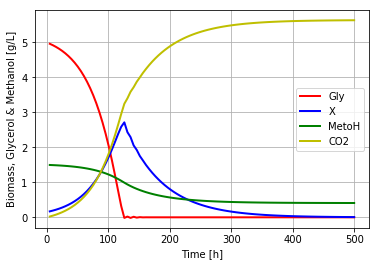

In [2]:
import numpy as np
from scipy.integrate import odeint
import cobra
import os
from os.path import join
data_dir="."
model=cobra.io.read_sbml_model(join(data_dir, "iMT1026v3.xml"))
import matplotlib.pyplot as plt
def kineticBlock(Gly,MetoH):
    [vGmax, K_Gly, vMmax, K_MetoH] = [0.53, 0.3, 0.16 , 0.3]
    f_Pyr = 0.93
    f_CO2 = 0.53
    v_Gly=vGmax*Gly/(K_Gly+Gly)
    v_MetoH=vMmax*MetoH/(K_MetoH+MetoH)
    LB_Pyr = -v_Gly*f_Pyr
    LB_CO2= -v_Gly*f_CO2
    return [v_Gly,LB_CO2,v_MetoH,LB_Pyr]

# Metabolic block
def metabolicBlock(v_Gly,v_MetoH,LB_CO2,LB_Pyr):
    model.reactions.get_by_id("Ex_glyc").lower_bound = -v_Gly 
    model.reactions.get_by_id("Ex_glyc").upper_bound = -v_Gly 
    model.reactions.get_by_id("Ex_pyr").lower_bound   = LB_Pyr
    model.reactions.get_by_id("Ex_co2").lower_bound   = LB_CO2
  
    solution = model.optimize()
    u = solution.objective_value
    v_Pyr = model.reactions.get_by_id("Ex_pyr").x
    v_CO2 = model.reactions.get_by_id("Ex_co2").x
   
    return [u,v_Pyr,v_CO2]
    
def f(y,t,params):
    V,VX,VGly,VMetoH,VCO2,Vpyr = y 
    F,u, v_Gly, v_MetoH, v_CO2,v_Pyr = params  
    MW_Gly,MW_MetoH,MW_CO2,MW_Pyr = [0.092,0.032,0.044,0.088]
    derivs=[ F,                  
            u*VX,                
            -v_Gly*MW_Gly*(VX),
            -v_MetoH*MW_MetoH*(VX), 
            v_CO2*MW_CO2*(VX),
            v_Pyr*MW_Pyr*(VX)]
           
    return derivs
            
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
    soln = odeint(f,y,time,args=(params,))
    V=soln[-1,0]
    X,Gly,MetoH,CO2,Pyr=soln[-1,1:6]/V
    return [V,X,Gly,MetoH,CO2,Pyr]    

u_path,V_path,X_path = [],[],[]
Gly_path,MetoH_path,CO2_path,Pyr_path = [],[],[],[]
v_Gly_path, v_MetoH_path=[],[]
def savePath(u,V,X,Gly,MetoH,CO2,Pyr,v_Gly,v_MetoH):
    global u_path,V_path,X_path
    global Gly_path,MetoH_path,CO2_path,Pyr_path
    global v_Gly_path, v_MetoH_path
    u_path += [u]
    V_path += [V]
    X_path += [X]
    Gly_path += [Gly]
    MetoH_path += [MetoH]
    CO2_path += [CO2]
    Pyr_path+=[Pyr]
    v_Gly_path += [v_Gly]
    v_MetoH_path +=[v_MetoH]
    
[Gly,MetoH]=[5,1.5]
[CO2,Pyr,Ace,Lac]=[0,0,0,0]
V,X=[1, 0.15]
F=0

time=np.linspace(0,500,100)
for i in range(len(time)):
    v_Gly,LB_CO2,v_MetoH,LB_Pyr = kineticBlock(Gly,MetoH)
    u,v_Pyr,v_CO2= metabolicBlock(v_Gly,LB_CO2,v_MetoH,LB_Pyr)
    if i==len(time)-1: continue
    y = [V,X*V,Gly*V,MetoH*V,CO2*V,Pyr*V]
    params = [F,u, v_Gly, v_MetoH, v_CO2,v_Pyr]
    V,X,Gly,MetoH,CO2,Pyr = dynamicBlock(y, params, time[i],time[i+1])
    savePath(u,V,X,Gly,MetoH,CO2,Pyr,v_Gly,v_MetoH)
    
plt.plot(time[1:600],Gly_path,'r',linewidth=2,label='Gly')
plt.plot(time[1:600],X_path,'b',linewidth=2,label='X')
plt.plot(time[1:600],MetoH_path,'g',linewidth=2,label='MetoH')
plt.plot(time[1:600],CO2_path,'y',linewidth=2,label='CO2')
plt.legend()
plt.ylabel('Biomass, Glycerol & Methanol [g/L]')
plt.xlabel('Time [h]')
plt.grid()
plt.show()